# Proposed CNN Model for Road Sound Datasets - Log-Mel Spectrograms



#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
from include import helpers

from keras import backend as keras_backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, LeakyReLU, ReLU, SpatialDropout2D, Activation, Conv2D 
from keras.layers import MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score  

Using TensorFlow backend.


#### * Setup

In [2]:
# Set your path to the original dataset
us8k_path = os.path.abspath('../Yi-Source-Code-3/input/vds_sound')
metadata_path = os.path.join(us8k_path, 'metadata/sound_vds15_vds16_14k.csv')
audio_path = os.path.join(us8k_path, 'audio')


In [3]:
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')
results_path = os.path.abspath('./results')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

In [4]:
# Required for the RTX GPU -- uncomment if using GTX or CPU
import keras.backend as K
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

In [5]:
# Define a labels array for future use
#labels = ['9 am', '13 pm', '19 pm']
#labels = ['morning', 'afternoon','evening']
#labels = ['down_1', 'down_2','down_3', 'up_4','up_5','up_6']
labels = ['1', '2','3', '4','5','6']


num_epochs = 200
num_batch_size = 64
file_name = 'conv5_gap_train_C6_MFCC_40'
model_path = os.path.join(models_path, file_name + '.hdf5')

#### * Load data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with coefficients from Mel Spectrogram of 174 frames and 40 MEL bands. Each feature was scaled between -1 and 1 and zero-centered during extraction.<br/>
<br/>

In [6]:
# Pre-processed MFCC coefficients
X = np.load("./data/X_C6_mels_40_14K.npy")
y = np.load("./data/y_C6_mels_40_14k.npy")

print(X.shape, y.shape)
# Metadata
metadata = pd.read_csv(metadata_path)

(14255, 40, 173) (14255,)


### 1. Data preparation: features + metadata

#### 1.1 Train / Test split
Note that we are using the same index order for both the Mel Spectrogram arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [7]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 2851 		 Train split: 11404
X test shape: (2851, 40, 173) 	 X train shape: (11404, 40, 173)
y test shape: (2851,) 		 y train shape: (11404,)


#### 1.2 One hot encode labels

In [8]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

#### 1.3 Reshape data

In [9]:
# How data should be structured
num_rows = 40
num_columns = 173 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
print('number of labels=',num_labels)

number of labels= 6


## 2. Proposed CNN network



#### 2.1 Model definition



In [10]:
def create_model(): 

    model = Sequential()
    #conv 1 (40x173)
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same',
    input_shape=(num_rows, num_columns, num_channels)))    
    model.add(ReLU())    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 

    
    #conv 2 (20x86)
    model.add(Conv2D(filters=64, kernel_size=(3, 3),  padding='same')) 
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 
 

    #conv 3 (10x43)
    model.add(Conv2D(filters=128, kernel_size=(3, 3),  padding='same')) 
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 

 
    #conv 4 (5x21)
    model.add(Conv2D(filters=256, kernel_size=(3,3),  padding='same'))  
    model.add(ReLU())   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4)) 
 
    #conv 5 (2x10)
    model.add(Conv2D(filters=512, kernel_size=(3,3),  padding='same'))  
    model.add(ReLU()) 
    model.add(Dropout(0.4)) 
    
    #conv 6 (1x5)
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Flatten())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5)) 
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

model = create_model() 


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [11]:
adam = Adam(lr=2e-4, beta_1=0.9, beta_2=0.999,epsilon=1e-08, decay=0.0)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 173, 32)       320       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 40, 173, 32)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 86, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 86, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 86, 64)        18496     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 20, 86, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 43, 64)       

In [12]:

# Save checkpoints

early_stopping = EarlyStopping(patience = 30) 
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, save_best_only=True)
callback_reduce_lr=ReduceLROnPlateau(monitor='val_loss',
                                     factor=0.1,
                                     min_lr=1e-6,
                                     patience=10,
                                     verbose=1)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=0.1,
                    callbacks=[early_stopping, callback_reduce_lr, checkpointer], 
                    verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"w")
file1.write('Training Time:' + str(duration))
file1.write('\n')
file1.close()





Train on 10263 samples, validate on 1141 samples
Epoch 1/200
10263/10263 [==============================] - 5s 523us/step - loss: 1.7518 - accuracy: 0.2161 - val_loss: 1.7463 - val_accuracy: 0.2419

Epoch 00001: val_loss improved from inf to 1.74628, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 2/200
10263/10263 [==============================] - 2s 217us/step - loss: 1.7048 - accuracy: 0.2472 - val_loss: 1.7035 - val_accuracy: 0.2980

Epoch 00002: val_loss improved from 1.74628 to 1.70354, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 3/200
10263/10263 [==============================] - 2s 217us/step - loss: 1.6811 - accuracy: 0.2583 - val_loss: 1.6703 - val_accuracy: 0.3287

Epoch 00003: val_loss improved from 1.70354 to 1.67025, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 

10263/10263 [==============================] - 2s 217us/step - loss: 0.4535 - accuracy: 0.8416 - val_loss: 0.3832 - val_accuracy: 0.8703

Epoch 00029: val_loss improved from 0.38846 to 0.38320, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 30/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.4423 - accuracy: 0.8423 - val_loss: 0.4660 - val_accuracy: 0.8212

Epoch 00030: val_loss did not improve from 0.38320
Epoch 31/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.4319 - accuracy: 0.8482 - val_loss: 0.3826 - val_accuracy: 0.8703

Epoch 00031: val_loss improved from 0.38320 to 0.38265, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 32/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.4286 - accuracy: 0.8513 - val_loss: 0.3758 - val_accuracy: 0.8703

Epoch 00032: val_loss impr

10263/10263 [==============================] - 2s 218us/step - loss: 0.2448 - accuracy: 0.9120 - val_loss: 0.3021 - val_accuracy: 0.8966

Epoch 00063: val_loss did not improve from 0.27249
Epoch 64/200
10263/10263 [==============================] - 2s 218us/step - loss: 0.2499 - accuracy: 0.9102 - val_loss: 0.3063 - val_accuracy: 0.9001

Epoch 00064: val_loss did not improve from 0.27249
Epoch 65/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.2401 - accuracy: 0.9150 - val_loss: 0.2921 - val_accuracy: 0.9010

Epoch 00065: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 00065: val_loss did not improve from 0.27249
Epoch 66/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.2146 - accuracy: 0.9245 - val_loss: 0.2596 - val_accuracy: 0.9132

Epoch 00066: val_loss improved from 0.27249 to 0.25963, saving model to D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\models\conv5_gap_train_C6_MFCC_40.hdf5
Epoch 67

10263/10263 [==============================] - 2s 217us/step - loss: 0.1733 - accuracy: 0.9399 - val_loss: 0.2652 - val_accuracy: 0.9194

Epoch 00100: val_loss did not improve from 0.24799
Epoch 101/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.1769 - accuracy: 0.9395 - val_loss: 0.2580 - val_accuracy: 0.9185

Epoch 00101: val_loss did not improve from 0.24799
Epoch 102/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.1803 - accuracy: 0.9369 - val_loss: 0.2598 - val_accuracy: 0.9167

Epoch 00102: val_loss did not improve from 0.24799
Epoch 103/200
10263/10263 [==============================] - 2s 218us/step - loss: 0.1807 - accuracy: 0.9357 - val_loss: 0.2641 - val_accuracy: 0.9124

Epoch 00103: val_loss did not improve from 0.24799
Epoch 104/200
10263/10263 [==============================] - 2s 217us/step - loss: 0.1809 - accuracy: 0.9364 - val_loss: 0.2542 - val_accuracy: 0.9185

Epoch 00104: val_loss did not improve from 0.24799

#### 2.4 General model evaluation
Note that we first load the checkpoint with the lowest validation loss achieved during training.

In [13]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.1023       97.0186
Test:             0.2454       91.9327
Normal diff         58.31 


Compared with the previous evaluation the model was able to train for more epochs when using Mel Spectrograms, and consequently, a higher accuracy and lower error where achieved.<br/>

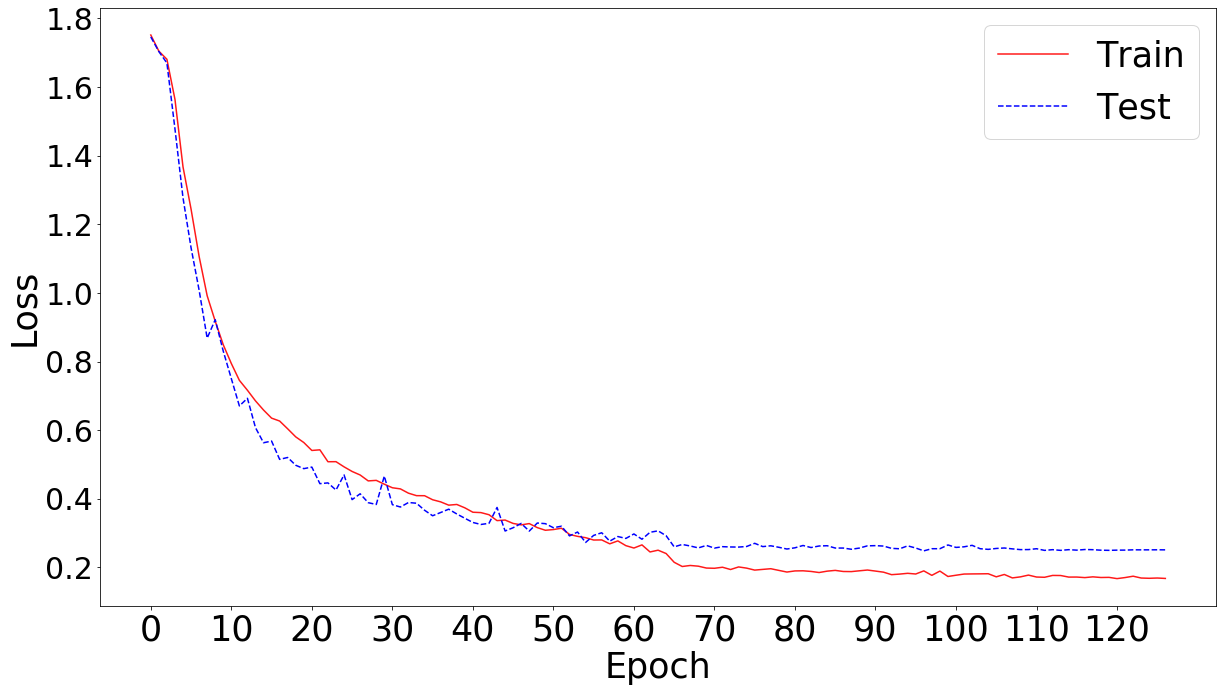

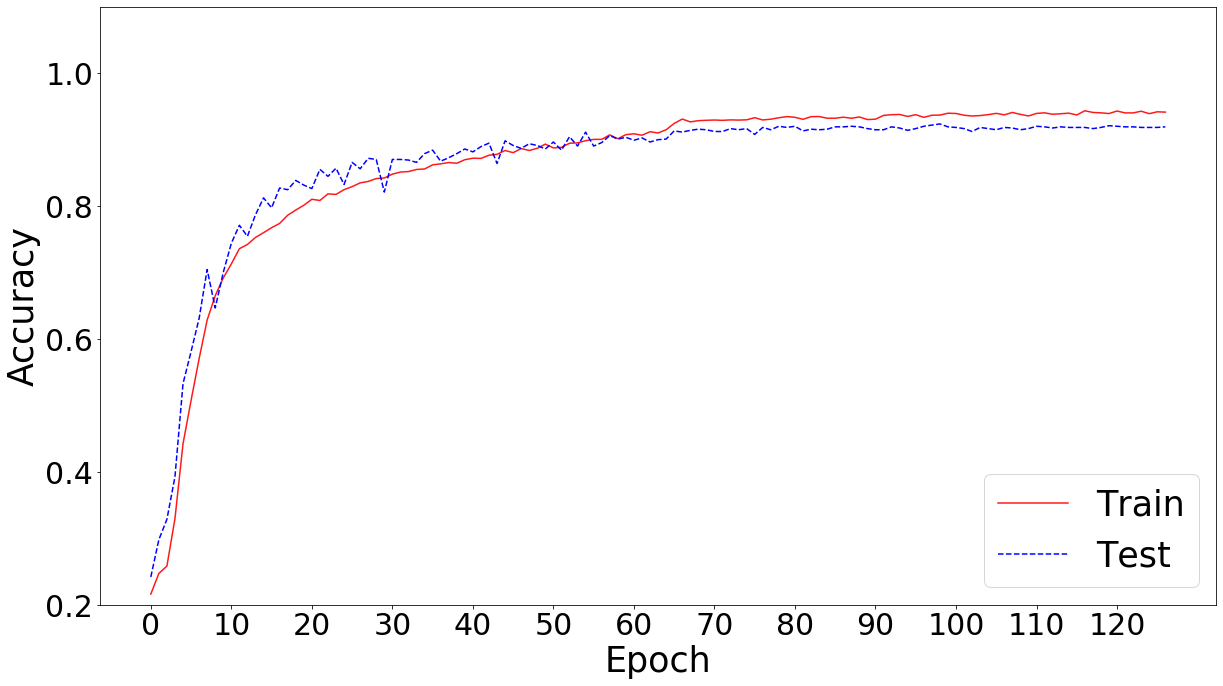

In [50]:
helpers.plot_train_history(history, x_ticks_vertical=True)

In [15]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


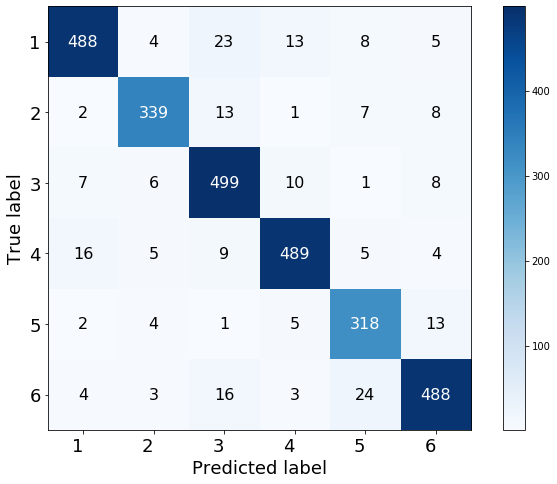

In [16]:
import importlib
importlib.reload(helpers)

# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          cmap=plt.cm.Blues,
                          size=(10,7))

In [17]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)
result_acc = 'acc_' + file_name
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_conv5_gap_train_C6_MFCC_40
  CLASS   ACCURACY
0     1  90.203327
1     2  91.621622
2     3  93.973635
3     4  92.613636
4     5  92.711370
5     6  90.706320


In [18]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(y_trues, yhat_probs)))
print("Precision: {0}".format(precision_score(y_trues, yhat_probs, average='weighted')))
print("Recall: {0}".format(recall_score(y_trues, yhat_probs, average='weighted')))
print("F1-Score: {0}".format(f1_score(y_trues, yhat_probs, average='weighted')))

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       541
           2       0.94      0.92      0.93       370
           3       0.89      0.94      0.91       531
           4       0.94      0.93      0.93       528
           5       0.88      0.93      0.90       343
           6       0.93      0.91      0.92       538

   micro avg       0.92      0.92      0.92      2851
   macro avg       0.55      0.55      0.55      2851
weighted avg       0.92      0.92      0.92      2851

Accuracy: 0.919326552086987
Precision: 0.9202509443454778
Recall: 0.919326552086987
F1-Score: 0.9194498820851249


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 10, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## 3. Deep Feature Clasification

CNN with non-softmax classification


### 3.1 Divide feature extraction layers and classification layers


In [19]:
# Layers definitions
from keras import backend as K
for l in range(len(model.layers)):
    print(l, model.layers[l])

0 <keras.layers.convolutional.Conv2D object at 0x000002130F1D8248>
1 <keras.layers.advanced_activations.ReLU object at 0x000002130F1D5E08>
2 <keras.layers.pooling.MaxPooling2D object at 0x000002137FC35288>
3 <keras.layers.core.Dropout object at 0x000002130F1F2588>
4 <keras.layers.convolutional.Conv2D object at 0x000002130F1FA788>
5 <keras.layers.advanced_activations.ReLU object at 0x000002130F205588>
6 <keras.layers.pooling.MaxPooling2D object at 0x000002130F20D808>
7 <keras.layers.core.Dropout object at 0x000002130F212B48>
8 <keras.layers.convolutional.Conv2D object at 0x000002130F212D08>
9 <keras.layers.advanced_activations.ReLU object at 0x000002130F2129C8>
10 <keras.layers.pooling.MaxPooling2D object at 0x000002130F231448>
11 <keras.layers.core.Dropout object at 0x000002130F231608>
12 <keras.layers.convolutional.Conv2D object at 0x000002130F23EC48>
13 <keras.layers.advanced_activations.ReLU object at 0x000002130F2319C8>
14 <keras.layers.pooling.MaxPooling2D object at 0x000002130F25

In [20]:
# feature extraction layer
getFeature = K.function([model.layers[0].input, K.learning_phase()],
                        [model.layers[20].output])

In [21]:
# classification layer
getPrediction = K.function([model.layers[21].input, K.learning_phase()],
                           [model.layers[22].output])

### 3.2 Get feature tensors for training and testing data


In [22]:
print(len(X_train))
exTrain = getFeature([X_train[:9500], 0])[0]

11404


In [23]:
exTest = getFeature([X_test, 0])[0]

In [24]:
# output of getFeature function
#exTrain[0]
#exTest[0]

###  3.3 Reshape target to fit to scikit-learn

In [25]:
sklearn_y_train= y_train[:9500].reshape(y_train[:9500].shape[0],)
sklearn_y_test = y_test

In [26]:
print(exTrain.shape, exTest.shape, sklearn_y_train.shape, sklearn_y_test.shape)

(9500, 256) (2851, 256) (9500,) (2851,)


In [27]:
from sklearn.model_selection import GridSearchCV

### 3.4   Scikit-learn Classifiers with feature extracted training data as input

We adopt four algorithms: Support Vector Machine (SVM), Random Forest (RF), L-Neareast Neighbor (KNN), and XGBoots (XGB) 

####  3.4.1 SVM

In [28]:

from sklearn.svm import SVC



start_svm = datetime.now()

parameters = {'kernel':['rbf'], 
              'C':[1, 10, 100, 1000],
              'gamma':[1e-3, 1e-4]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(exTrain, sklearn_y_train)

time_svm = datetime.now() - start_svm
print("Training completed in time of svm: ", time_svm)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time SVM:' +  str(time_svm))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of svm:  0:01:09.062438


In [29]:
svmclf = clf.best_estimator_
svmclf.fit(exTrain, sklearn_y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:

y_testSVM = svmclf.predict(exTest)


# visualize confusion matrix on heat map
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_svm = confusion_matrix(sklearn_y_test, y_testSVM)
'''
helpers.plot_confusion_matrix(cm_svm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(8,8))
'''



'\nhelpers.plot_confusion_matrix(cm_svm,\n                          labels, \n                          normalized=False, \n                          title="Model Performance", \n                          cmap=plt.cm.Blues,\n                          size=(8,8))\n'

In [31]:
accuracies = helpers.acc_per_class(cm_svm)
result_acc = 'acc_SVM'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_SVM
  CLASS   ACCURACY
0     1  90.388170
1     2  92.702703
2     3  93.032015
3     4  93.750000
4     5  90.379009
5     6  92.379182


In [32]:
# Build classification report
re = classification_report(sklearn_y_test, y_testSVM, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testSVM)))

              precision    recall  f1-score   support

           1       0.93      0.90      0.92       541
           2       0.94      0.93      0.93       370
           3       0.90      0.93      0.92       531
           4       0.93      0.94      0.93       528
           5       0.91      0.90      0.91       343
           6       0.92      0.92      0.92       538

   micro avg       0.92      0.92      0.92      2851
   macro avg       0.61      0.61      0.61      2851
weighted avg       0.92      0.92      0.92      2851

Accuracy: 0.9217818309365136


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 9, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 3.4.2 Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

start_rf = datetime.now()

parameters = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [1.0, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": [10, 20, 50]}
rclf = RandomForestClassifier()
rgclf = GridSearchCV(rclf, param_grid=parameters)
rgclf.fit(exTrain, sklearn_y_train)

time_rf = datetime.now() - start_rf
print("Training completed in time of RF: ", time_rf)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time RF:' +  str(time_rf))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of RF:  0:06:27.019174


In [34]:
rclf = rgclf.best_estimator_
rclf.fit(exTrain, sklearn_y_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [35]:
y_testRF = rclf.predict(exTest)

cm_RF = confusion_matrix(sklearn_y_test, y_testRF)

'''
helpers.plot_confusion_matrix(cm_RF,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(8,8))
'''


'\nhelpers.plot_confusion_matrix(cm_RF,\n                          labels, \n                          normalized=False, \n                          title="Model Performance", \n                          cmap=plt.cm.Blues,\n                          size=(8,8))\n'

In [36]:
accuracies = helpers.acc_per_class(cm_RF)
result_acc = 'acc_RF'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_RF
  CLASS   ACCURACY
0     1  90.203327
1     2  92.972973
2     3  93.032015
3     4  93.750000
4     5  90.670554
5     6  91.635688


In [37]:
# Build classification report
re = classification_report(sklearn_y_test, y_testRF, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testRF)))

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       541
           2       0.94      0.93      0.94       370
           3       0.90      0.93      0.92       531
           4       0.93      0.94      0.93       528
           5       0.90      0.91      0.90       343
           6       0.91      0.92      0.92       538

   micro avg       0.92      0.92      0.92      2851
   macro avg       0.61      0.61      0.61      2851
weighted avg       0.92      0.92      0.92      2851

Accuracy: 0.9207295685724307


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 9, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 3.4.3 K nearest neighbors

In [38]:
from sklearn.neighbors import KNeighborsClassifier

start_Knn = datetime.now()

parameters = {"n_neighbors": [1, 5, 10, 30],
              "weights": ['uniform', 'distance'],
              "metric": ['minkowski','euclidean','manhattan'],
              "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute']}
kclf = KNeighborsClassifier()
kgclf = GridSearchCV(kclf, param_grid=parameters)
kgclf.fit(exTrain, sklearn_y_train)

time_knn = datetime.now() - start_Knn
print("Training completed in time of KNN: ", time_knn)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time KNN:' +  str(time_knn))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of KNN:  0:10:31.024849


In [39]:
kclf = kgclf.best_estimator_
kclf.fit(exTrain, sklearn_y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='distance')

In [40]:
y_testKNN = kclf.predict(exTest)

cm_KNN = confusion_matrix(sklearn_y_test, y_testKNN)

'''
helpers.plot_confusion_matrix(cm_KNN,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(8,8))
'''

'\nhelpers.plot_confusion_matrix(cm_KNN,\n                          labels, \n                          normalized=False, \n                          title="Model Performance", \n                          cmap=plt.cm.Blues,\n                          size=(8,8))\n'

In [41]:
accuracies = helpers.acc_per_class(cm_KNN)
result_acc = 'acc_KNN'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_KNN
  CLASS   ACCURACY
0     1  90.203327
1     2  94.324324
2     3  93.596987
3     4  92.613636
4     5  92.419825
5     6  91.821561


In [42]:
# Build classification report
re = classification_report(sklearn_y_test, y_testKNN, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testKNN)))

              precision    recall  f1-score   support

           1       0.94      0.90      0.92       541
           2       0.93      0.94      0.94       370
           3       0.91      0.94      0.92       531
           4       0.94      0.93      0.93       528
           5       0.90      0.92      0.91       343
           6       0.93      0.92      0.92       538

   micro avg       0.92      0.92      0.92      2851
   macro avg       0.62      0.62      0.62      2851
weighted avg       0.92      0.92      0.92      2851

Accuracy: 0.923886355664679


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 9, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### 3.4.4  Xgboost

In [43]:
from xgboost import XGBClassifier

start_xgb = datetime.now()

parameters = {'max_depth':[6], 'eta':[0.3], 'objective':['multi:softprob ']}

xclf = XGBClassifier()
xgclf = GridSearchCV(xclf, param_grid=parameters)
xgclf.fit(exTrain, sklearn_y_train)

time_xgb = datetime.now() - start_xgb
print("Training completed in time of XGB: ", time_xgb)
file1 = open(os.path.join(models_path, 'time_' + file_name + ".txt"),"a")
file1.write('Time XGB:' +  str(time_xgb))
file1.write('\n')
file1.close()

C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Training completed in time of XGB:  0:00:25.433003


In [44]:
xclf = xgclf.best_estimator_
xclf.fit(exTrain, sklearn_y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.3, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
y_testXGB = xclf.predict(exTest)

cm_XGB = confusion_matrix(sklearn_y_test, y_testXGB)

'''
helpers.plot_confusion_matrix(cm_XGB,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(8,8))
'''

'\nhelpers.plot_confusion_matrix(cm_XGB,\n                          labels, \n                          normalized=False, \n                          title="Model Performance", \n                          cmap=plt.cm.Blues,\n                          size=(8,8))\n'

In [46]:
accuracies = helpers.acc_per_class(cm_XGB)
result_acc = 'acc_XGB'
result_path = os.path.join(results_path, result_acc)
print(result_path)
df=pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="CLASS", ascending=True)

print(df)

df.to_csv(result_path + '.csv')

D:\KISTI\Project\052020-Traffic-Sound\Yi-Source-Code-3\results\acc_XGB
  CLASS   ACCURACY
0     1  89.463956
1     2  93.783784
2     3  93.408663
3     4  93.560606
4     5  90.670554
5     6  92.193309


In [47]:
# Build classification report
re = classification_report(sklearn_y_test, y_testXGB, labels=[1,2,3,4,5,6,7,8,9], target_names=labels) 
print(re)
print("Accuracy: {0}".format(accuracy_score(sklearn_y_test, y_testXGB)))
print("Precision: {0}".format(precision_score(y_trues, yhat_probs, average='weighted')))
print("Recall: {0}".format(recall_score(y_trues, yhat_probs, average='weighted')))
print("F1-Score: {0}".format(f1_score(y_trues, yhat_probs, average='weighted')))

              precision    recall  f1-score   support

           1       0.93      0.89      0.91       541
           2       0.95      0.94      0.94       370
           3       0.91      0.93      0.92       531
           4       0.92      0.94      0.93       528
           5       0.92      0.91      0.91       343
           6       0.92      0.92      0.92       538

   micro avg       0.92      0.92      0.92      2851
   macro avg       0.62      0.61      0.61      2851
weighted avg       0.92      0.92      0.92      2851

Accuracy: 0.9217818309365136
Precision: 0.9202509443454778
Recall: 0.919326552086987
F1-Score: 0.9194498820851249


C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1870: UserWarning: labels size, 9, does not match size of target_names, 6
  .format(len(labels), len(target_names))
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\user\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
